**Assignment # 2, CNN over Fasion MNIST**

In this assignment you are requested to build a convolutional network and train it over the Fasion MNIST data, which is a collection of 28X28 back and white images, classified into 10 different classes of clothing items. For more information about Fashion MNIST you may refer to: 
https://github.com/zalandoresearch/fashion-mnist 

**Imports**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from torch.utils.data import RandomSampler,DataLoader
from torchvision.transforms import Compose,RandomHorizontalFlip,Grayscale,Resize,RandomCrop,ToTensor

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

from PIL import Image
import matplotlib.pyplot as plt


import pickle
from time import time
from IPython.display import clear_output

Set a batch_size :

In [ ]:
# BATCH_SIZE = 4
BATCH_SIZE = 64     # approved by kfir

**Loading Fashion MNIST**

In [ ]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress','Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=ToTensor())

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=ToTensor())


# Use dataloaders for train and test (batch size is 4)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**Checking Batch**

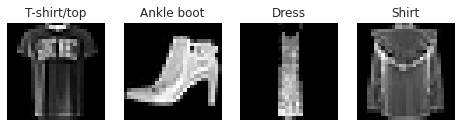

In [ ]:
images, labels = iter(trainloader).next()

# show images
f, ax = plt.subplots(1,4,figsize=(8,3)) # 4 = images.shape[0]
for i in range(4):
  ax[i].imshow(images[i][0],cmap='gray', vmin=0, vmax=1)
  ax[i].axis('off')
  ax[i].set_title(classes[labels[i]])

**Set DEVICE (cuda/cpu)**

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

**Record Results**

In [ ]:
df_results = pd.DataFrame(columns=['Device','Metric','Score'])

# **Part 1**: Implementing a CNN network for Fashion MNIST
Here is what you need to do; you are encoureged to look at notebook "DL Notebook 9 - CIFAR CNN" when trying to complete the next steps.


Write a network CNNFMnist, that has the following architecture:

* Convolution with 10 3X3 filters
* Relu
* Max pool with 2X2
* Convolution with 5 3X3 filters
* Relu
* Convolution with 16 3X3 filters
* Relu
* Max pool with 2X2
* Liner, output size 128
* Relu
* Liner, output size 64
* Relu
* Liner, output size 10

**CONV2D Parameters:**

in_channels (int) – Number of channels in the input image

out_channels (int) – Number of channels produced by the convolution

kernel_size (int or tuple) – Size of the convolving kernel

stride (int or tuple, optional) – Stride of the convolution. Default: 1

padding (int or tuple, optional) – Zero-padding added to both sides of the input. Default: 0

padding_mode (string, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'

dilation (int or tuple, optional) – Spacing between kernel elements. Default: 1

groups (int, optional) – Number of blocked connections from input channels to output channels. Default: 1

bias (bool, optional) – If True, adds a learnable bias to the output. Default: True

In [ ]:
class CNNFMnist(nn.Module):

    def __init__(self):
        super(CNNFMnist, self).__init__()
        # Your code goes here
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=5, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=16, kernel_size=3)

        self.fc1 = nn.Linear(in_features=256, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=10)


    def forward(self, x):
        # Your code goes here
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.conv2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = torch.flatten(x, start_dim=1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.out(x)
        return x     

**Testing Architecture:**

In [ ]:
model = CNNFMnist()
inputs, labels = iter(trainloader).next()

inputs.shape, model(inputs).shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 10]))

Write a code that trains the network with FashionMNIST train dataset, for classification (use cross entropy, and SGD).
Run the network for at least 10 epochs, over the entire dataset. Make sure to print the loss over the train set as well as the **test set** over time (say, every 1000 batches, but it's up to you), so you will know where you are during training. 

Note, measuring loss of test is similar to measuring loss over the train test. However, make sure not to run the test images in back propagation. Use them only in forward and calulate the average loss over the entire test set. Since it will make the training process run slower, you should measure loss for the test set only at the end of an epoch (so overall you get 10 loss values for the test set). You are encoureged to write a different function for claculating the loss of the test set, and then call it from the training procedure.


You should collect the loss values in an array, so you can plot then into two curves, one for train and one for test.

In addition, you should measure the time it takes you to train the network completely.



In [ ]:
# Your code goes here
def train_model(DEVICE,model,trainloader,testloader=None,verbose=False,n_epochs=10,lr=1e-3):

  total_len = len(trainloader)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  loss_values = []
  loss_values_test = []
  for epoch in range(n_epochs):  


      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          
          inputs, labels = data
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)

          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          
          loss.backward()
          
          optimizer.step()
         

          # print statistics
          running_loss += loss.item()
          if verbose and ((i+1) % 5000 == 0): 
            print('epoch={} \t samples={}/{}\t\tloss: {}'.format(epoch + 1, i + 1, total_len, running_loss / i) ) 
            
      # save loss of epoch
      loss_values.append(running_loss / len(trainloader))

      if testloader is not None:
        with torch.no_grad():
          running_loss = 0.0
          for i, data in enumerate(testloader, 0):
            
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
          loss_values_test.append(running_loss / len(testloader))
        
      #loss_values_eval.append(eval_model(DEVICE,model,verbose=False))

  if testloader is not None:
    return loss_values,loss_values_test
    
  return loss_values
  

Write a function that evaluates the resulted model over the entire test data of FashionMNIST. Provide a single accuracy number.

In [ ]:
# Your code goes here
def eval_model(DEVICE,model,testloader,verbose=False):

  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  if verbose:
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

  # accuracy
  return correct / total

**Train & Eval on CPU:**

In [ ]:
DEVICE = 'cpu'
model = CNNFMnist().to(DEVICE)

train_time = time()
train_loss_cpu,test_loss_cpu = train_model(DEVICE,model,trainloader,testloader,verbose=False)
train_time = (time()-train_time)/60.0

eval_time = time()
eval_acc = eval_model(DEVICE,model,testloader,verbose=True)
eval_time = time()-eval_time

Accuracy of the network on the test images: 82 %


''

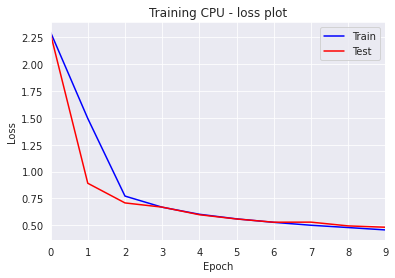

In [ ]:
# plot loss values
ax1 = sns.lineplot(data=train_loss_cpu,label='Train',color='blue');
ax1 = sns.lineplot(data=test_loss_cpu,label='Test',color='red',ax=ax1);
ax1.set_title('Training CPU - loss plot')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.set(xlim=(0, 9))
ax1.legend()
;

In [ ]:
# record results for later
df_results.loc[len(df_results)] = ['CPU','Train Time (min)',train_time]
df_results.loc[len(df_results)] = ['CPU','Eval Time (sec)',eval_time]
df_results.loc[len(df_results)] = ['CPU','Accuracy',eval_acc]

# **Part 2**: Training with a GPU 
You are requested to change your code to use the GPU instead of the CPU.
This can be easily done bu converting every torch.tensor to torch.cuda.tensor. 

Specific instructions:
* Change the hardware equipent of your colab notebook. To do that, go to the "Runtime" menu, and then to "Change runtime type". In the dialog box, change "Hardware accelerator" to GPU.
* Please follow the lines that were commented out with the comment    # -- For GPU
* Also, remove the lines that have the comment # -- For CPU

Train your network again and compare training time.

In [ ]:
DEVICE = 'cuda'   #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNFMnist().to(DEVICE)

train_time = time()
train_loss_gpu,test_loss_gpu = train_model(DEVICE,model,trainloader,testloader,verbose=False)
train_time = (time()-train_time)/60.0

eval_time = time()
eval_acc = eval_model(DEVICE,model,testloader,verbose=True)
eval_time = time()-eval_time

Accuracy of the network on the test images: 79 %


''

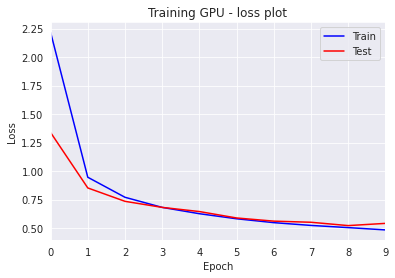

In [ ]:
# plot loss values
ax2 = sns.lineplot(data=train_loss_gpu,label='Train',color='blue');
ax2 = sns.lineplot(data=test_loss_gpu,label='Test',color='red',ax=ax2);
ax2.set_title('Training GPU - loss plot')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set(xlim=(0, 9))
ax2.legend()
;

In [ ]:
# record results for later
df_results.loc[len(df_results)] = ['GPU','Train Time (min)',train_time]
df_results.loc[len(df_results)] = ['GPU','Eval Time (sec)',eval_time]
df_results.loc[len(df_results)] = ['GPU','Accuracy',eval_acc]

**Compare - CPU vs GPU**

''

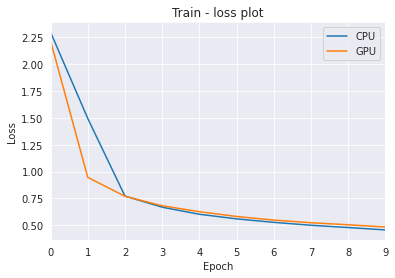

In [ ]:
# plot loss values
ax = sns.lineplot(data=train_loss_cpu,label='CPU');
ax = sns.lineplot(data=train_loss_gpu,label='GPU',ax=ax);
ax.set_title('Train - loss plot')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set(xlim=(0, 9))
ax.legend()
;

''

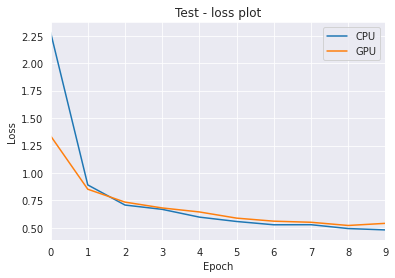

In [ ]:
# plot loss values
ax = sns.lineplot(data=test_loss_cpu,label='CPU');
ax = sns.lineplot(data=test_loss_gpu,label='GPU',ax=ax);
ax.set_title('Test - loss plot')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set(xlim=(0, 9))
ax.legend()
;

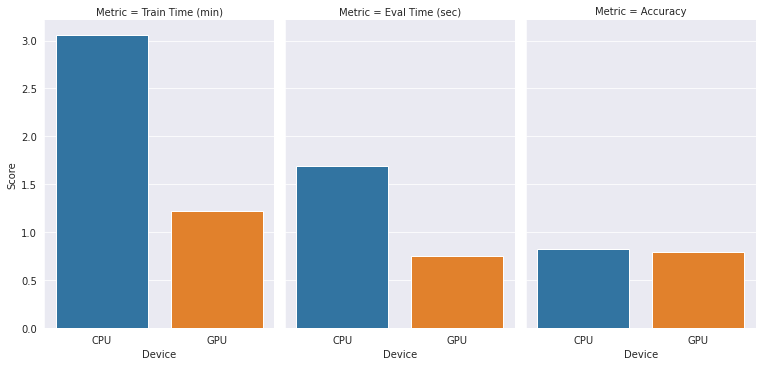

In [ ]:
sns.catplot(x="Device", y="Score", col="Metric", data=df_results, kind="bar", height=5, aspect=0.7);

We can easly see that the GPU's train and eval time are lower. While the accuracy is the same.

<br><br><br>
<br><br><br>
<br><br><br>

# **Part 3**: Transfer Learning
Training data is a valuable resource, and sometimes there is not enough of it for training a neural netowrk at scale. To handle this situation, one approach is transfer learning, where we train our network on a different related task, and then switch to train it on the downstream task that we focus on. 

In this last part of the assignment, you are requested to pretrain your network on CIFAR-10, then train it on Fashion-MNIST, and measure its contribution to the results. To do that, please follow the steps:

In [ ]:
'''
Note:
It's unclear if u want us to change the already been writen code or to craate a new functions based on the initial code, although we would have changed the initial code.
So here is a new section with the code from before - and we mentioned the changes :)
'''

"\nNote:\nIt's unclear if u want us to change the already been writen code or to craate a new functions based on the initial code, although we would have changed the initial code.\nSo here is a new section with the code from before - and we mentioned the changes :)\n"

In [ ]:
# Your code goes here
def train_model(DEVICE,model,trainloader,testloader=None,verbose=False,n_epochs=10,lr=1e-3): 

  model = model.to(DEVICE) # changed

  total_len = len(trainloader)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  loss_values = []
  loss_values_test = []
  for epoch in range(n_epochs):  


      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          
          inputs, labels = data
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)

          optimizer.zero_grad()

          _, outputs = model(inputs)  # changed
          
          loss = criterion(outputs, labels)
          
          loss.backward()
          
          optimizer.step()
         

          # print statistics
          running_loss += loss.item()
          if verbose and ((i+1) % 5000 == 0): 
            print('epoch={} \t samples={}/{}\t\tloss: {}'.format(epoch + 1, i + 1, total_len, running_loss / i) ) 
            
      # save loss of epoch
      loss_values.append(running_loss / len(trainloader))

      if testloader is not None:
        with torch.no_grad():
          running_loss = 0.0
          for i, data in enumerate(testloader, 0):
            
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            _, outputs = model(inputs)  # changed
            loss = criterion(outputs, labels)
            running_loss += loss.item()
          loss_values_test.append(running_loss / len(testloader))
        
      #loss_values_eval.append(eval_model(DEVICE,model,verbose=False))

  if testloader is not None:
    return loss_values,loss_values_test
    
  return loss_values
  

In [ ]:
# A little change in the eval function

def eval_model(DEVICE,model,testloader,verbose=False):

  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          _, outputs = model(images)                  # changed

          _, predicted = torch.max(outputs.data, 1)
          
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  if verbose:
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

  # accuracy
  return correct / total

**Step 1**

Modify your CNNFMnist implementation to return the output of the layer one before last after Relu (Linear layer of size 64, above) in addition to the final output. For example:

```
def forward(self, x):
  ...
  return h, out
```

In [ ]:
# A little change in the CNNFMnist class

class CNNFMnist(nn.Module):

    def __init__(self):
        super(CNNFMnist, self).__init__()
        # Your code goes here
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=5, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=16, kernel_size=3)

        self.fc1 = nn.Linear(in_features=256, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=10)


    def forward(self, x):
        # Your code goes here
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.conv2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = torch.flatten(x, start_dim=1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        h = F.relu(x)          # changed

        out = self.out(h)      # changed
        return h,out           # changed


model = CNNFMnist()
model(iter(trainloader).next()[0])[0].shape,model(iter(trainloader).next()[0])[1].shape

(torch.Size([64, 64]), torch.Size([64, 10]))


and train it on the training-set part of CIFAR-10.   
Use batch size of 4, and train it for at least 10 epochs. 

Note that CIFAR-10 images are of different shapes (3X32X32), therefore a conversion into 1X28X28 is needed.   
To do that, when you load CIFAR-10 using a torchvision Dataset, you can use the transformer torchvision.transforms.Grayscale(num_output_channels=1) in order to convert the images to a 1X32X32 grayscale volume:

```
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                    torchvision.transforms.ToTensor()]))
```
Then, from each 1X32X32 image, sample 10 1X28X28 images at random positions, and use them for training (*optional* - for data augmentation, if you want, you can also generate the reflection of each of the 10 images and add them the training set).

In [ ]:
trainset_list = []

def append_trainset(trainset_list,transform):
  d = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=Compose(transform))
  trainset_list.append(d)

# original 
transform = [
            Grayscale(num_output_channels=1),
            Resize(size=28),
            ToTensor()
            ]

# original reflected
transform_reflect = [
            Grayscale(num_output_channels=1),
            Resize(size=28),
            RandomHorizontalFlip(p=1),
            ToTensor()
            ]

# random crop
transform_crop = [
            Grayscale(num_output_channels=1),
            RandomCrop(size=28),
            ToTensor()
            ]

# random crop & reflected
transform_crop_reflect = [
            Grayscale(num_output_channels=1),
            RandomHorizontalFlip(p=1),
            RandomCrop(size=28),
            ToTensor()
            ]


# transforming images 
append_trainset(trainset_list,transform)
append_trainset(trainset_list,transform_reflect)        # optional augmentation
for _ in range(10): 
  append_trainset(trainset_list,transform_crop)
  append_trainset(trainset_list,transform_crop_reflect) # optional augmentation

# merging 
merged_trainset = torch.utils.data.ConcatDataset(trainset_list)

# trainloader
trainloader_CIFAR10 = torch.utils.data.DataLoader(merged_trainset, batch_size=BATCH_SIZE, shuffle=True)

# testing
clear_output(wait=True)
print('Trainsets count:{}   Dataset length:{}   Batch shape:{}'.format(len(trainset_list),len(trainloader_CIFAR10.dataset),iter(trainloader_CIFAR10).next()[0].shape))

Trainsets count:22   Dataset length:1100000   Batch shape:torch.Size([64, 1, 28, 28])


In [ ]:
trainset_FashionMNIST = torchvision.datasets.FashionMNIST(root='./data', train=True, download=False, transform=ToTensor())

testset_FashionMNIST = torchvision.datasets.FashionMNIST(root='./data', train=False, download=False, transform=ToTensor())

# Use dataloaders for train and test (batch size is 4)
trainloader_FashionMNIST = DataLoader(trainset_FashionMNIST, batch_size=BATCH_SIZE, shuffle=True)
testloader_FashionMNIST = DataLoader(testset_FashionMNIST, batch_size=BATCH_SIZE, shuffle=False)

**Setp 2**

Once done, write a new Module CNNFMnist2, which uses CNNFMnist as one of its sub modules, followed by some additional layers.   
The output of CNNFMnist that goes into the next layer, should be the output of the 64 neuron one-before-last layer, as described above.  
CNNFMnist2 should have the following architecture:

* CNNFMnist
* Liner, output size 32
* Relu
* Liner, output size 16
* Relu
* Liner, output size 10

Make sure to allow the user to assign a pre-trained version CNNFMnist as a member of the module. For example:

```
class CNNFMnist2(nn.Module):
    def __init__(self, trained_cnnfmnist_model):
        super(CNNFMnist2, self).__init__()
        self.trained_cnnfmnist_model = trained_cnnfmnist_model
        self.fc1 = nn.Linear(64, 32)
        ...
```

In [ ]:
class CNNFMnist2(nn.Module):
    def __init__(self, trained_cnnfmnist_model):
        super(CNNFMnist2, self).__init__()
        self.trained_cnnfmnist_model = trained_cnnfmnist_model
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)

    def forward(self, x):
        x,_ = self.trained_cnnfmnist_model(x)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        h = F.relu(x)    

        out = self.fc3(x)  
        return h, out     

    # helper functions
    def freeze_sub_model(self):
        # no need of eval() - no use of dropout/batch norm/etc.
        # self.trained_cnnfmnist_model.eval() 

        for p in self.trained_cnnfmnist_model.parameters():
          p.requires_grad  = False


    def unfreeze_sub_model(self):
        # self.trained_cnnfmnist_model.train()
        for p in self.trained_cnnfmnist_model.parameters():
          p.requires_grad  = True


# testing 
model = CNNFMnist2(CNNFMnist())
model(iter(trainloader).next()[0])[1].shape

torch.Size([64, 10])

**Step 3**

Train and eval CNNFMnist2 on Fashion-MNIST a few times:
- Using the pre-trained version of CNNFMnist.
- Using a fresh CNNFMnist instance (without training it).
- (Optional) Using the pre-trained version of CNNFMnist, after freezing its weights using the .eval() function.

Report on evaluation results (accuracy) for all of those cases.

<br><br><br>

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

<br><br>
Save results:

In [ ]:
df_results_step3 = pd.DataFrame(columns=['Version','Metric','Score'])

<br><br>
Creating the initial models :

In [ ]:
model_CNNFMnist_1 = CNNFMnist()
train_model(DEVICE,model_CNNFMnist_1,trainloader_CIFAR10,verbose=False,n_epochs=5) # more epochs will take too much time

model_CNNFMnist_2 = CNNFMnist()

# copy the model
model_CNNFMnist_3 = pickle.loads(pickle.dumps(model_CNNFMnist_1))   # deep copy does not work as well

<br><br><br><br>
Using the pre-trained version of CNNFMnist:

Accuracy of the network on the test images: 86 %


''

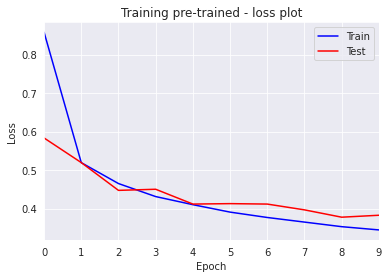

In [ ]:
# Using the pre-trained version of CNNFMnist.
model_CNNFMnist2_1 = CNNFMnist2(model_CNNFMnist_1)

train_time = time()
train_acc_pre,test_acc_pre = train_model(DEVICE,model_CNNFMnist2_1,trainloader_FashionMNIST,testloader_FashionMNIST,verbose=False,n_epochs=10)
train_time = (time()-train_time)/60.0

eval_acc = eval_model(DEVICE,model_CNNFMnist2_1,testloader_FashionMNIST,verbose=True)

# record results for later
df_results_step3.loc[len(df_results_step3)] = ['pre-trained','Train Time (min)',train_time]
df_results_step3.loc[len(df_results_step3)] = ['pre-trained','Accuracy',eval_acc]

# plot loss values
ax1 = sns.lineplot(data=train_acc_pre,label='Train',color='blue');
ax1 = sns.lineplot(data=test_acc_pre,label='Test', color='red',ax=ax1);
ax1.set_title('Training pre-trained - loss plot')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.set(xlim=(0, 9))
ax1.legend()
;

<br><br><br><br>
Using a fresh CNNFMnist instance (without training it):

Accuracy of the network on the test images: 70 %


''

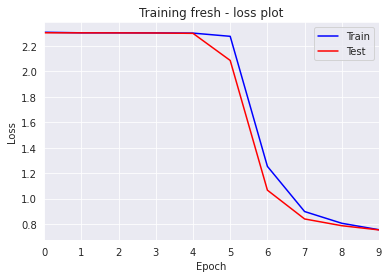

In [ ]:
# Using a fresh CNNFMnist instance (without training it).
model_CNNFMnist = CNNFMnist()
model_CNNFMnist2_2 = CNNFMnist2(model_CNNFMnist_2)

train_time = time()
train_acc_fresh, test_acc_fresh = train_model(DEVICE,model_CNNFMnist2_2,trainloader_FashionMNIST,testloader_FashionMNIST,verbose=False,n_epochs=10)
train_time = (time()-train_time)/60.0

eval_acc = eval_model(DEVICE,model_CNNFMnist2_2,testloader_FashionMNIST,verbose=True)

# record results for later
df_results_step3.loc[len(df_results_step3)] = ['fresh','Train Time (min)',train_time]
df_results_step3.loc[len(df_results_step3)] = ['fresh','Accuracy',eval_acc]

# plot loss values
ax2 = sns.lineplot(data=train_acc_fresh,label='Train',color='blue');
ax2 = sns.lineplot(data=test_acc_fresh,label='Test',color='red',ax=ax2);
ax2.set_title('Training fresh - loss plot')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set(xlim=(0, 9))
ax2.legend()
;

<br><br><br><br>
Using the pre-trained version of CNNFMnist, after freezing its weights using the .eval() function:

Accuracy of the network on the test images: 76 %


''

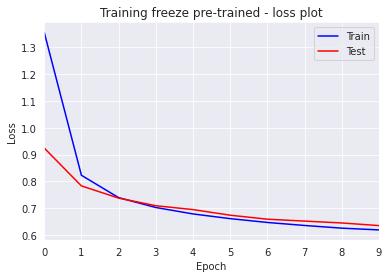

In [ ]:
# Using the pre-trained version of CNNFMnist.
model_CNNFMnist2_3 = CNNFMnist2(model_CNNFMnist_3)
model_CNNFMnist2_3.freeze_sub_model()    # freezing

train_time = time()
train_acc_freeze,test_acc_freeze = train_model(DEVICE,model_CNNFMnist2_3,trainloader_FashionMNIST,testloader_FashionMNIST,verbose=False,n_epochs=10)
train_time = (time()-train_time)/60.0

eval_acc = eval_model(DEVICE,model_CNNFMnist2_3,testloader_FashionMNIST,verbose=True)

# record results for later
df_results_step3.loc[len(df_results_step3)] = ['freeze pre-trained','Train Time (min)',train_time]
df_results_step3.loc[len(df_results_step3)] = ['freeze pre-trained','Accuracy',eval_acc]

# plot loss values
ax3 = sns.lineplot(data=train_acc_freeze,label='Train',color='blue');
ax3 = sns.lineplot(data=test_acc_freeze,label='Test',color='red',ax=ax3);
ax3.set_title('Training freeze pre-trained - loss plot')
ax3.set_ylabel('Loss')
ax3.set_xlabel('Epoch')
ax3.set(xlim=(0, 9))
ax3.legend()
;

<br><br><br><br><br>
<br><br><br><br><br>
## Results & Conclusions:

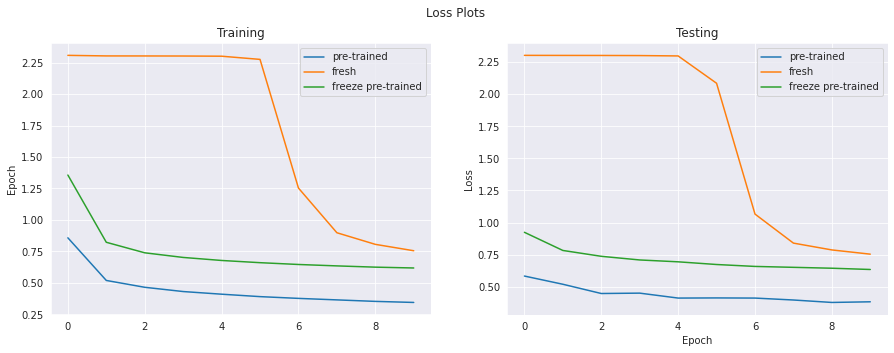

In [ ]:
# plot loss values
fig, axes = plt.subplots(1, 2,figsize=(15,5))
fig.suptitle('Loss Plots')

# train
ax = axes[0]
ax = sns.lineplot(data=train_acc_pre,label='pre-trained',ax=ax);
ax = sns.lineplot(data=train_acc_fresh,label='fresh',ax=ax);
ax = sns.lineplot(data=train_acc_freeze,label='freeze pre-trained',ax=ax);
ax.set_title('Training')
ax.set_ylabel('Loss')
ax.set_ylabel('Epoch')
ax.legend()

# test
ax = axes[1]
ax = sns.lineplot(data=test_acc_pre,label='pre-trained',ax=ax);
ax = sns.lineplot(data=test_acc_fresh,label='fresh',ax=ax);
ax = sns.lineplot(data=test_acc_freeze,label='freeze pre-trained',ax=ax);
ax.set_title('Testing')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend()
;

plt.show()

<br><br>

We can see that the two pre-trained versions start with a lower loss already from the first epoch !

<br>

This makes sense, since the model has already some previous knowledge and this is a great proof that the transfer learning really works here.

<br>

We can observe that the fresh version still has potential to become better if it would have been trained using more epochs. This also makes sense, due to the fact that this network started without any previous knowledge and had to learn everything from the beginning.

<br>

The frozen weights version has a hard time keep up with the un-frozen version. As we know, this happens due to the inability (frozen) of the first layers of the net to adapt/learn and change accordingly (update).

<br><br><br>


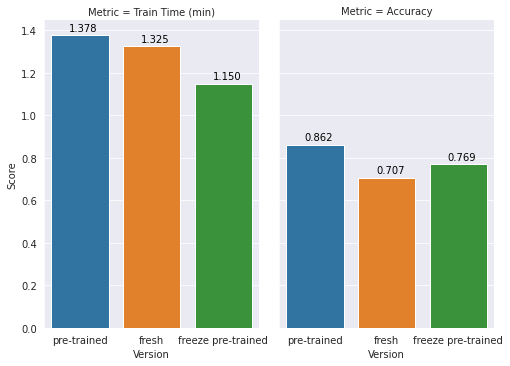

In [ ]:
g = sns.catplot(x="Version", y="Score", col="Metric", data=df_results_step3, kind="bar", height=5, aspect=0.7);

for s in range(2):
  ax = g.facet_axis(0,s)
  for p in ax.patches:
    ax.text(p.get_x()+0.25, p.get_height() +0.02, '{0:.3f}'.format(p.get_height()), color='black', rotation='horizontal', size='medium')

<br><br>
And not surprisingly, we can see that the training time of the freeze pre-trained model is the fastest.  
This is because there are significantly less parameters to update(learn/train)  since some of the layes are frozen.

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>




# Submission - Assignment 2

**NotebookLink:**  
*https://colab.research.google.com/drive/11xFzvflXKiiry31dCaLU5cZShJFYsrzb?usp=sharing*  

<br>

**Submitted by:**  
> *300420379 Millis Sahar   
301833833 Segal Tomer  
203745161 Unger Amit*

*(3 students - approved by Kfir)*  

<br><br>

##### Note: We are using a batch size of 64 (Approved by Kfir)

<br><br>

```
Sample of the elements in the dataset:
```

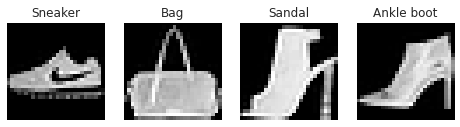

<br><br>
<br><br>
<hr>
<br><br>
<br><br>

```
CPU Experiment:
*   Plot of loss curves (train in blue, test in red)
```

<br>

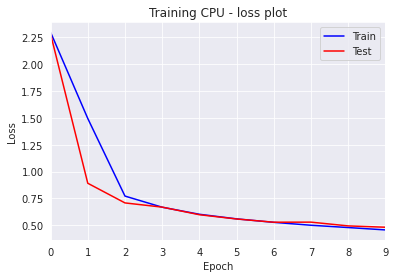

```
GPU Experiment:
*   Plot of loss curves (train in blue, test in red)
```



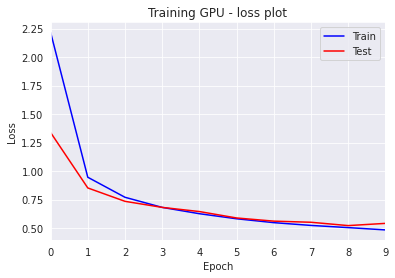

```
Experiment: 
* Training Time
 GPU has the advantage.
```



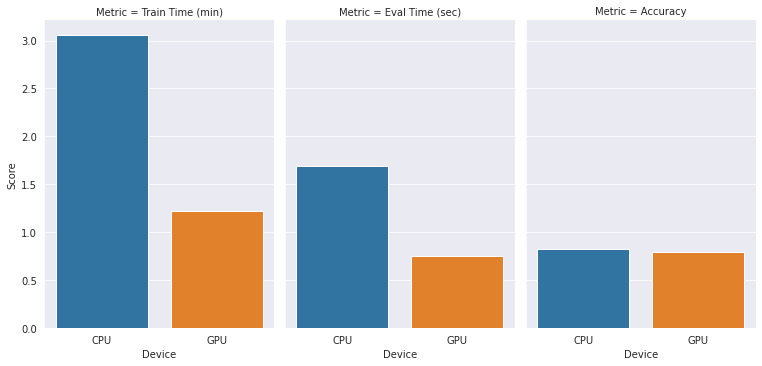

*GPU has the advantage regarding training time & evaluation time, while the accuracy ramain the same.*

<br><br>
<hr>
<br><br>

```
Transfer Learning Experiment:
* Accuracy results on test set for the 2-3 implemeted settings (see above)
```



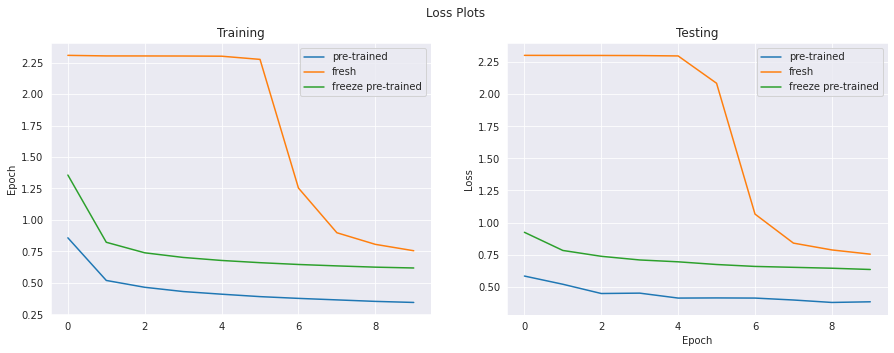

<br>  
We can see that the two pre-trained versions **start with a  lower loss** already from the **first epoch**!     

This makes sense, since the model has already some previous knowledge and this is a great proff that the transfer learning really works here.   

While the fresh version still needs more epochs to train on, to get better.
Which also make sense, due to the fact that the lower layers of the fresh model "seen" significantly less images.  

Although, the freeze version has a hard time keep up with the un-freeze version.
As we know, this happens due to the inability(frozen) of first layers of the net to adapt/learn and change accordingly (update).
<br><br>

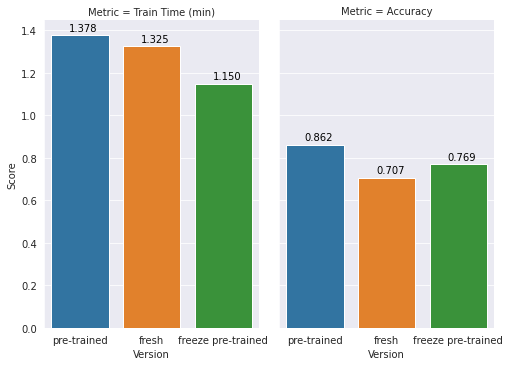


<br><br><br>

Regarding **training time**:  
  - The fresh and pre-train versions are about the same - due to the equal amount of paramaters. (if we added a convergence condition it might be different)
  - The frozen version, not surprisingly, has a lower training time and is the **fastest**.  This is because there are significantly less parameters to change(train\learn\update) since some of the layes are frozen.

<br>
<br>

Regarding **Accuracy**:  
  - The fresh version has the lowest accuracy, because the lower lavers "seen" less images to train on. This is a good proff that **transfer learning works!**
  - The frozen version has good performence, but due to the freezon lower layers it has a hard time to generelize to the "new" dataset.
  - The pre-train version has the best accuracy, and this make a lot of sense to us. Due to the transfer learning it comes with a lot of knowlege, and still has the ability(unfrozen layer)  to fit the "new" dataset accordingly.

<br>
<br>

Regarding the **best model** conclusion:  
  *In this case we will choose the pre-train version. But with a different batch, dataset or networks - we can understand the huge adventage of transfer learning with frozen lower layers.*


<br><br><br>

```
Inside the notebook, you can find all our conclutions, analysis, aditional plots and much more...

Thanks :) 
```